# Processing your Eclipse Photo with SunPy

Requirements
* Python 3
* matplotlib
* scipy
* sunpy >= 0.8
* skimage
* exifread
* astropy

In [222]:
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from matplotlib.patches import Circle
import piexif
import sunpy
import sunpy.map
from datetime import datetime
from skimage.transform import hough_circle, hough_circle_peaks
import astropy.wcs
from astropy.coordinates import EarthLocation, SkyCoord
import sunpy.coordinates
import exifread
%matplotlib inline

In [223]:
sunpy.system_info()

 SunPy Installation Information


###########
 General
###########
Time : Monday, 14. August 2017 04:27PM UT
System : Darwin
Processor : i386
Arch : 64bit
SunPy : 0.8.dev8265
SunPy_git : 96e3334048c63d295aaa422cb292d0946233992b
OS: Mac OS X 10.12.6 (i386)


###########
 Required Libraries 
###########
Python: 3.5.2
NumPy: 1.13.1
SciPy: 0.19.1
matplotlib: 2.0.2
Astropy: 2.0
Pandas: 0.20.2


###########
 Recommended Libraries 
###########
beautifulsoup: 4.6.0
PyQt: NOT INSTALLED
SUDS: 0.6
Sqlalchemy: 1.1.5
Requests: 2.18.2


Replace the following with your photo filename

In [224]:
f = '../sample-photos/total_solar_eclipse.jpg'
exif_f = '../sample-photos/Sun_with_one_AR.jpg'

## First let's try to get some metadata from the file

In [225]:
tags = exifread.process_file(open(exif_f, 'rb'))

In [226]:
tags

{'EXIF ApertureValue': (0x9202) Ratio=2744161/500000 @ 688,
 'EXIF BodySerialNumber': (0xA431) ASCII=042021018255 @ 736,
 'EXIF ColorSpace': (0xA001) Short=sRGB @ 484,
 'EXIF CustomRendered': (0xA401) Short=Normal @ 532,
 'EXIF DateTimeDigitized': (0x9004) ASCII=2017:07:15 14:44:00 @ 660,
 'EXIF DateTimeOriginal': (0x9003) ASCII=2017:07:15 14:44:00 @ 640,
 'EXIF ExifVersion': (0x9000) Undefined=0230 @ 340,
 'EXIF ExposureBiasValue': (0x9204) Signed Ratio=0 @ 696,
 'EXIF ExposureMode': (0xA402) Short=Manual Exposure @ 544,
 'EXIF ExposureProgram': (0x8822) Short=Manual @ 292,
 'EXIF ExposureTime': (0x829A) Ratio=1/250 @ 624,
 'EXIF FNumber': (0x829D) Ratio=67/10 @ 632,
 'EXIF Flash': (0x9209) Short=Flash did not fire, compulsory flash mode @ 436,
 'EXIF FocalLength': (0x920A) Ratio=400 @ 712,
 'EXIF FocalPlaneResolutionUnit': (0xA210) Short=3 @ 520,
 'EXIF FocalPlaneXResolution': (0xA20E) Ratio=5021939/2048 @ 720,
 'EXIF FocalPlaneYResolution': (0xA20F) Ratio=5021939/2048 @ 728,
 'EXIF 

In [227]:
def _convert_to_degress(value):
    """
    Helper function to convert the GPS coordinates stored in the EXIF to degress in float format
    :param value:
    :type value: exifread.utils.Ratio
    :rtype: float
    """
    d = float(value.values[0].num) / float(value.values[0].den)
    m = float(value.values[1].num) / float(value.values[1].den)
    s = float(value.values[2].num) / float(value.values[2].den)

    return d + (m / 60.0) + (s / 3600.0)
    
def get_exif_location(exif_data):
    """
    Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)
    """
    lat = None
    lon = None

    gps_latitude = exif_data.get('GPS GPSLatitude', None)
    gps_latitude_ref = exif_data.get('GPS GPSLatitudeRef', None)
    gps_longitude = exif_data.get('GPS GPSLongitude', None)
    gps_longitude_ref = exif_data.get('GPS GPSLongitudeRef', None)

    if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
        lat = _convert_to_degress(gps_latitude)
        if gps_latitude_ref.values[0] != 'N':
            lat = 0 - lat

        lon = _convert_to_degress(gps_longitude)
        if gps_longitude_ref.values[0] != 'E':
            lon = 0 - lon

    return lat, lon

In [228]:
exif_dict = piexif.load(exif_f)
if "EXIF ExposureTime" in tags:
    exposure_tag = tags['EXIF ExposureTime']
    exposure_time = exposure_tag.values[0].num / exposure_tag.values[0].den * u.s
    print("Exposure time of {0} found!".format(exposure_time))
if "Image Artist" in tags:
    author_str = tags['Image Artist'].values
    print("Author name of {0} found!".format(author_str))
if "Image DateTime" in tags:
    datetime_str = tags['Image DateTime'].values.replace(' ', ':').split(':')
    time = datetime(int(datetime_str[0]), int(datetime_str[1]), 
                    int(datetime_str[2]), int(datetime_str[3]),
                    int(datetime_str[4]), int(datetime_str[5]))
    print("Image time of {0} found!".format(str(time)))
if "Image Model" in tags:
    camera_model_str = tags['Image Model'].values
    print("Camera model of {0} found!".format(camera_model_str))
lat, lon = get_exif_location(exif_dict)
if ((lat != None) and (lon != None)):
    gps = [lat, lon] * u.deg
    print("Found GPS location of {0}, {1} found!".format(gps[0], gps[1]))

Exposure time of 0.004 s found!
Author name of Steven D. Christe found!
Image time of 2017-07-16 08:34:09 found!
Camera model of Canon EOS 70D found!


The following variables need to be defined. If they were not found in the EXIF data please define them below

In [229]:
# exposure_time = 0.1 * u.s
# camera_model_str = 'Canon 70D'
# author_str = 'Julius Berkowski'
time = datetime(2017, 8, 21, 17, 25, 0)
gps = [44.37197, -116.87393] * u.deg

## Read in the image data

In [230]:
# read in the image and flip it so that it is what we took
im_rgb = np.flipud(matplotlib.image.imread(f))
# remove color info
im = np.average(im_rgb, axis=2)

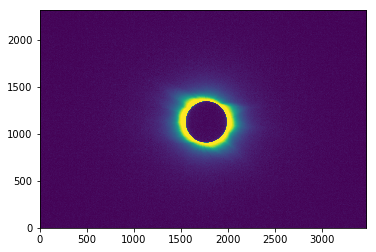

In [231]:
plt.imshow(im, origin='lower')

# Get info from the image

We need the following information from the image
* the location of the center of the Sun/Moon and 
* the scale of the picture which we get from the size of the Sun/Moon in pixels

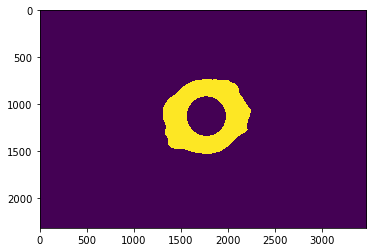

In [232]:
blur_im = ndimage.gaussian_filter(im, 8)
mask = blur_im > blur_im.mean() * 3
plt.imshow(mask)

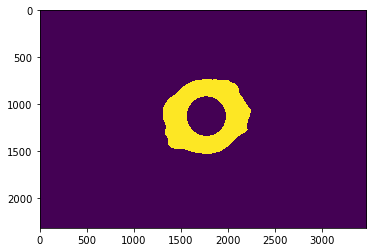

In [233]:
label_im, nb_labels = ndimage.label(mask)
plt.imshow(label_im)

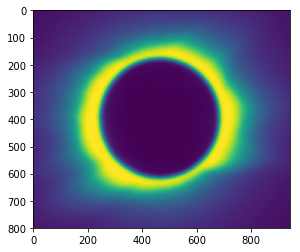

In [234]:
slice_x, slice_y = ndimage.find_objects(label_im==1)[0]
roi = blur_im[slice_x, slice_y]
plt.imshow(roi)

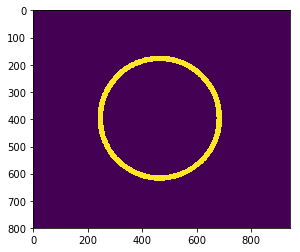

In [235]:
sx = ndimage.sobel(roi, axis=0, mode='constant')
sy = ndimage.sobel(roi, axis=1, mode='constant')
sob = np.hypot(sx, sy)
plt.imshow(sob > (sob.mean() * 5))

In [236]:
from skimage.transform import hough_circle, hough_circle_peaks

hough_radii = np.arange(np.floor(np.mean(sob.shape)/4), np.ceil(np.mean(sob.shape)/2), 1)
hough_res = hough_circle(sob > (sob.mean() * 5), hough_radii)

# Select the most prominent 5 circles
accums, cy, cx, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
print(cx, cy, radii)

[396] [465] [ 221.]


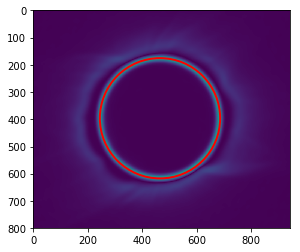

In [237]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
circ = Circle([cy, cx], radius=radii, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(sob)
ax.add_patch(circ)
plt.show()

Now let's check it with the original image

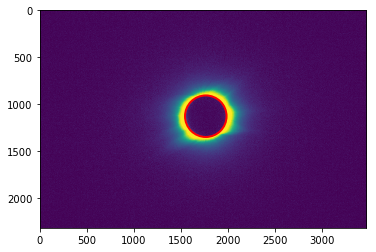

In [238]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
im_cx = (cx + slice_x.start) * u.pix
im_cy = (cy + slice_y.start) * u.pix
im_radius = radii * u.pix
circ = Circle([im_cy.value, im_cx.value], radius=im_radius.value, facecolor='none', edgecolor='red', linewidth=2)
ax.imshow(im)
ax.add_patch(circ)
plt.show()

### Let's now put it all into a function (ignore)

In [ ]:
def find_sun_center_and_scale(im):
    # first blur the image slightly to smooth it
    blur_im = ndimage.gaussian_filter(im, 8)
    mask = blur_im > blur_im.mean() * 3
    
    # label the image to find the region where the Sun is
    label_im, nb_labels = ndimage.label(mask)
    slice_x, slice_y = ndimage.find_objects(label_im==1)[0]
    roi = blur_im[slice_x, slice_y]

    # take the derivative to find the edge of the Sun/Moon
    sx = ndimage.sobel(roi, axis=0, mode='constant')
    sy = ndimage.sobel(roi, axis=1, mode='constant')
    sob = np.hypot(sx, sy)
    
    # finally fit a circle to it
    hough_radii = np.arange(np.floor(np.mean(sob.shape)/4), np.ceil(np.mean(sob.shape)/2), 1)
    hough_res = hough_circle(sob > (sob.mean() * 5), hough_radii)

    # Select the most prominent 5 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
    
    return cx, cy, radii[0]

In [ ]:
cx, cy, radius = find_sun_center_and_scale(im)

# Getting information about the Sun

Let's now get the distance between the Earth and the Sun at the time the photo was taken

In [ ]:
dsun = sunpy.coordinates.get_sunearth_distance(time.isoformat())
print(dsun)

The size of the Sun in the sky is then

In [ ]:
rsun_obs = np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec')
print(rsun_obs)

The image plate scale is then

In [ ]:
plate_scale = rsun_obs / im_radius
print(plate_scale)

We also need the solar rotation angle

In [ ]:
loc = EarthLocation(lat=gps[0], lon=gps[1])
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, time)

In [ ]:
hgln_obs = 0 * u.deg # sunpy.coordinates.get_sun_L0(time)
hglt_obs = sunpy.coordinates.get_sun_B0(time)
print("{0} {1}".format(hglt_obs, hgln_obs))

# Define your WCS object and header

In [ ]:
w = astropy.wcs.WCS(naxis=2)
w.wcs.crpix = [im_cy[0].value, im_cx[0].value]
w.wcs.cdelt = np.ones(2) * plate_scale.to('arcsec/pix').value
w.wcs.crval = [0, 0]
w.wcs.ctype = ['TAN', 'TAN']
w.wcs.cunit = ['arcsec', 'arcsec']
w.wcs.dateobs = time.isoformat()

Using this object we can now create the sunpy map header

In [ ]:
header = dict(w.to_header())
header.update({'CROTA2': solar_rotation_angle.to('deg').value})
header.update({'DSUN_OBS': dsun.to('m').value})
header.update({'HGLN_OBS': hgln_obs.to('deg').value})
header.update({'HGLT_OBS': hglt_obs.to('deg').value})
header.update({'CTYPE1': 'HPLN-TAN'})
header.update({'CTYPE2': 'HPLT-TAN'})
header.update({'RSUN': dsun.to('m').value})
header.update({'RSUN_OBS': np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec').value})

Now add metadata about the photograph.

In [ ]:
header.update({'AUTHOR': author_str})
header.update({'EXPTIME': exposure_time.to('s').value})
header.update({'TELESCOP': camera_model_str})
header.update({'INSTRUME': camera_model_str})
header.update({'DETECTOR': camera_model_str})

In [ ]:
header

# Creating SunPy Map

In [ ]:
m = sunpy.map.Map((im, header))
m

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.show()

# Overplot the location of Regulus

In [ ]:
regulus = SkyCoord(ra='10h08m22.311s', dec='11d58m01.95s', distance=79.3 * u.lightyear, frame='icrs').transform_to(m.coordinate_frame)

In [ ]:
regulus

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=m)
m.plot(axes=ax)
ax.plot_coord(regulus, '*w')
m.draw_grid(axes=ax)
m.draw_limb(axes=ax)
plt.show()

# Plot an SDO Image of the Sun on your photo